# Wormlike polymers and DNA regulation

Requirements
+ matplotlib
+ numpy
+ scipy


<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/hw/random_dimer.ipynb) -->

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/hw/random_dimer.ipynb)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The wormlike chain model (Work in progress)

The [wormlike chain model](https://chem.libretexts.org/Bookshelves/Biological_Chemistry/Concepts_in_Biophysical_Chemistry_(Tokmakoff)/02%3A_Macromolecules/09%3A_Macromolecular_Mechanics/9.02%3A_Worm-like_Chain) is a simple thermodynamic model of a polymer chain. It is commonly used to study the properties of DNA and other biological macromolecules that tend to become straight at low temperatures. A wormlike chain describes a polymer as a series of $N$ bonds joined end-to-end. A bond a position $i \in \{1, 2, \ldots, N\}$ consists of a fixed-length tangent vector $\mathbf{t}_i \in \mathbb{R}^3$ that points along the chain. At low temperature, the chain adopts a straight conformation, in which the tangent vectors are parallel to each other.

The energy of the wormlike chain is given by the sum of the inner products of adjacent bonds on the chain.
$$
    E = \kappa \sum_{i=1}^{N-1} (1 - \mathbf{t}_i \cdot \mathbf{t}_{i+1})
$$

where $\kappa$ is a physical parameter that characterizes the bending stiffness of the chain. This can be seen as torsional analogue of the spring constant of a linear chain of springs. At low temperature, all of the tangent vectors are parallel to each other, and the energy is zero. However, as the temperature is increased, the chain will adopt more random conformations, and the energy will increase. At very high temperatures, the chain resembles a random walk. The wormlike chain model thus qualitatively resembles a Heisenberg spin system with nearest-neighbor interactions, with the tangent vectors playing the role of spins.

We use the notation $\mathbb{T} \equiv \{\mathbf{t}_1, \mathbf{t}_2, \ldots, \mathbf{t}_N\}$ to represent the entire chain's configuration at a given time.


### Properties of the wormlike chain

A key parameter of the wormlike chain is the persistence length, which is the length over which the tangent vectors remain correlated. The persistence length is given by
$$
    l_p = \kappa b \beta
$$
where $b$ is the bond length and $\beta = 1/k_B T$ is the inverse temperature. At a given temperature, the persistence length determines the typical length over which the chain's tangent vectors remain correlated. Qualitatively, it measures the chain's stiffness in terms of the typical size scales over which it appears to be straight. In the same manner that the correlation length of a spin system diverges at low temperatures, the persistence length diverges at high temperatures and long chains. For finite chains, this means that the persistence length approaches the chain length $l_p \to N b$.

The correlation function between the tangent vectors at two points $i$ and $j$ separated by a distance $s$ is thus given by
$$
    C(s) = \langle \mathbf{t}_i \cdot \mathbf{t}_{i+s} \rangle \propto \exp(-s/l_p)
$$
where $s \equiv \lvert i - j \rvert$ is the separation between the two points and the average is taken over many configurations of the chain. 

Another key property of the wormlike chain is the end-to-end distance, describing the distance between the first and last points of the chain. Intuitively, we expect this distance to *decrease* with increasing temperature, as the chain becomes more flexible and the ends can come closer together. Conversely, this quantity should approach the system size $N b$ in the limit of low temperatures.

Analytically, the average end-to-end distance can be computed by taking the large-$N$ and [computing an integral over the chain length coordinate $s$]((https://chem.libretexts.org/Bookshelves/Biological_Chemistry/Concepts_in_Biophysical_Chemistry_(Tokmakoff)/02%3A_Macromolecules/09%3A_Macromolecular_Mechanics/9.02%3A_Worm-like_Chain)). This results in the expression
$$
    R^2 = \langle \| \mathbf{t}_1 - \mathbf{t}_N \| \rangle^2 = 2 l_p N b (1 - 2 \frac{N b}{l_p} (1 - \exp(-N b / l_p)))
$$
where $\mathbf{R}$ is the end-to-end vector and $N b$ is the total length of the chain when fully extended.

### Implementing the Wormlike chain model

We are now going to implement the wormlike chain model, and use Monte Carlo simulations to sample its equilibrium properties and verify the two analytical results above. Our implementation will first define a new object `Bond` representing a unit-length tangent vector in 3D space. This object will essentially wrap a numpy array of shape (3,) with a unit norm. However, it will also provide a `rotate_in_place` method that rotates the vector in place by an arbitrary angle about an arbitrary axis. To do this, it implements [the Rodrigues rotation formula.](https://mathworld.wolfram.com/RodriguesRotationFormula.html)

Our `WormlikeChainMC` class will use an ordered list of `Bond` objects to represent the chain's unit tangent vectors. This is stored in the `bonds` attribute. The constructor initializes all of the bonds in the chain to be straight, with small random transverse displacements.

In order to map this problem onto a Monte Carlo algorithm, we need to (1) define a function that sweeps through the chain and attempts to rotate each bond about a random axis by a random angle, and (2) define a function that computes the chain's bending energy before and after the proposed move, and then performs a Metropolis acceptance test to determine whether to accept the proposed move. 

Recall that, for a Metropolis algorithm, we compute the initial energy $E$ of a given chain configuration $\mathbb{T}$. We then propose a new configuration $\mathbb{T}'$ and calculate its energy $E(\mathbb{T}')$. We then compute the change in energy $\Delta E = E(\mathbb{T}') - E(\mathbb{T})$. If $\Delta E \leq 0$, we accept the proposed move. Otherwise, we accept the move with probability $\exp(-\beta \Delta E)$, where $\beta = 1/k_B T$ is the inverse temperature.

In order to encourage our chain to equilibrate faster, we will add some structure to the proposed moves. Rather than attempting to update all bonds at once to generate a proposed new configuration $\mathbb{T}'$, we will attempt to update one bond at a time. As you will see below, this simplies this calculation of change in energy $\Delta E$. Instead of selecting bonds at random to update, we will attempt to update each bond on the chain sequentially, known as a "sweep".

In our implementation, the proposed move will consist of rotating a single bond about a random axis by a random angle, using the `rotate_in_place` method of the `Bond` object.


### To Do

*Please complete the following tasks and answer the included questions. You can edit a Markdown cell in Jupyter by double-clicking on it. To return the cell to its formatted form, press `[Shift]+[Enter]`.*

1. Suppose you have two chains, $\mathbb{T}_1$ and $\mathbb{T}_2$, that differ only in the orientation of single bond, $\mathbf{t}_i$ at site $i$. Calculate (analytically) a minimal expression for the change in the energy $\Delta E$ between the two chains. Using this result, implement the `delta_energy` method in the `WormlikeChainMC` class that takes the current chain configuration, an index $i$, and a proposed new bond $\mathbf{t}_i'$. The function should compute the change in energy $\Delta E$ between the current and proposed chain.

```
    Your Answer: complete the code below
```

2. Implement the `sweep` method in the `WormlikeChainMC` class. A full sweep of the chain consists of visiting each bond individually and attempting to rotate it about a random axis by a random angle, and then computing the change in energy of the proposed chain based on the entire chain's energy. After computing the change in energy from the proposed move, the method should accept or reject the move using a Metropolis acceptance test that depends on the inverse temperature $\beta$. The method should then proceed to the next bond, until all bonds have been attempted. Test your implementation using the code below to check that the chain configuration updates as expected.

```
    Your Answer: complete the code below
```

3. Using the code provided below, compare the analytical and Monte Carlo results for the chain's end-to-end distance and tangent correlation function. What causes the discrepancies?

```
    Your Answer:
```

4. In our implementation, we performed the Monte Carlo update by sweeping through every bond in the chain and running a Metropolis acceptance test separately. However, this introduces a subtle non-physical bias in the sampling of states. What is the origin of this bias? Why do you think we opted to sweep through the chain, instead of updating all bonds at once and doing a single Metropolis acceptance test on the entire chain?

```
    Your Answer:
```

5. An DNA strand consists of a sequence of nucleotides resembling a polymer. When part of a DNA strand becomes looped within a cell, it becomes harder for the cell's machinery to access the looped region and create RNA and eventually proteins. Looping thus represents a physical mechanism that can control the expression of genes within a cell. Which physical property of the wormlike chain model would you expect to control whether not a given part of the DNA sequence is looped? For more information on this problem, see [Geggier & Vologodskii, 2010](https://doi.org/10.1073/pnas.1004809107).

```
    Your Answer: 
```

In [ ]:
import numpy as np

def random_unit_vec(rng: np.random.Generator):
    """
    Args:
        rng (np.random.Generator): RNG.

    Returns:
        np.ndarray: Random unit vector on S^2 (shape (3,)).
    """
    z = rng.uniform(-1.0, 1.0)
    phi = rng.uniform(0.0, 2.0 * np.pi)
    r = np.sqrt(max(0.0, 1.0 - z * z))
    return np.array([r * np.cos(phi), r * np.sin(phi), z], dtype=float)


class Bond:
    """Unit-length bond/tangent vector in R^3 with in-place rotations.

    Parameters:
        v (np.ndarray): Initial vector (shape (3,)); will be normalized.

    Attributes:
        v (np.ndarray): Unit vector (shape (3,)).

    Methods:
        rotate_in_place(axis: np.ndarray, angle: float): Rotate about an 
            arbitrary axis by Rodrigues' formula; re-normalize.
        copy(): Return a copy of the Bond.
    """

    def __init__(self, v):
        v = np.asarray(v, dtype=float).reshape(3)
        n = np.linalg.norm(v)
        if n == 0.0:
            raise ValueError("Zero vector is not allowed for Bond.")
        self.v = v / n

    def rotate_in_place(self, axis: np.ndarray, angle: float):
        """
        Given an arbitrary axis and angle, rotate a vector in place by Rodrigues' 
        formula, and then re-normalize.

        Args:
            axis (np.ndarray): Axis of rotation (shape (3,)).
            angle (float): Angle of rotation (radians).

        Returns:
            None
        """
        a = np.asarray(axis, dtype=float).reshape(3)
        na = np.linalg.norm(a)
        if na == 0.0:
            # Degenerate axis: no rotation
            return
        a /= na
        c, s = np.cos(angle), np.sin(angle)
        v = self.v
        # Rodrigues rotation
        v_rot = v * c + np.cross(a, v) * s + a * (np.dot(a, v)) * (1.0 - c)
        # Guard against FP drift
        self.v = v_rot / np.linalg.norm(v_rot)

    # Numpy interop: treat Bond like its vector
    def __array__(self, dtype=None):
        return np.asarray(self.v, dtype=dtype)

    def copy(self):
        return Bond(self.v.copy())


class WormlikeChainMC:
    """Discrete 3D wormlike chain with Metropolis updates in tangent space.

    The chain is represented by N unit bond vectors (Bond objects) of fixed length b.
    Positions are reconstructed by r_{k+1} = r_k + b t_k (with r_0 at the origin).
    Bending energy: E = kappa * sum_i (1 - t_i · t_{i+1}).

    Parameters:
        N (int): Number of bonds.
        b (float): Bond length (segment length).
        kappa (float): Bending stiffness (k_B T units). Persistence length l_p = kappa * b.
        beta (float): Inverse temperature 1/T (k_B=1).
        seed (int | None): RNG seed.

    Attributes:
        N (int): Number of bonds.
        b (float): Bond length.
        kappa (float): Bending stiffness.
        beta (float): Inverse temperature.
        rng (np.random.Generator): RNG.
        bonds (list[Bond]): List of N Bond instances (unit vectors).
    """
    def __init__(self, N=400, b=1.0, kappa=20.0, beta=1.0, seed=None):
        self.N, self.b = int(N), float(b)
        self.kappa, self.beta = float(kappa), float(beta)
        self.rng = np.random.default_rng(seed)

        # start nearly straight with small transverse noise, then normalize per Bond
        base = np.tile(np.array([1.0, 0.0, 0.0], dtype=float), (self.N, 1))
        base += 0.05 * self.rng.normal(size=base.shape)
        self.bonds = [Bond(v) for v in base]

        ## calculate the persistence length
        self.lp = self.kappa * self.b

    def tangent_vectors(self):
        """Stack current bond vectors into a (N, 3) ndarray."""
        return np.vstack([b.v for b in self.bonds])

    def positions(self):
        """Return positions r_k, k=0..N as shape (N+1,3) with r_0 = 0."""
        r = np.zeros((self.N + 1, 3), dtype=float)
        np.cumsum(self.b * self.tangent_vectors(), axis=0, out=r[1:])
        return r

    def energy(self):
        """Compute the total bending energy of the chain."""
        t = self.tangent_vectors()
        dots = (t[:-1] * t[1:]).sum(axis=1)
        return float(self.kappa * np.sum(1.0 - dots))

    def _local_deltaE(self, i: int, trial_vec: np.ndarray):
        """Energy change from replacing t_i by trial_vec (only neighbors matter)."""
        dE = 0.0
        if i > 0:
            dE += self.kappa * ((1.0 - float(np.dot(trial_vec, self.bonds[i - 1].v)))
                                - (1.0 - float(np.dot(self.bonds[i].v, self.bonds[i - 1].v))))
        if i < self.N - 1:
            dE += self.kappa * ((1.0 - float(np.dot(trial_vec, self.bonds[i + 1].v)))
                                - (1.0 - float(np.dot(self.bonds[i].v, self.bonds[i + 1].v))))
        return float(dE)

    def sweep(self, step_size: float = 0.3):
        """
        One Monte Carlo sweep consists of attempting N local rotations, one for each 
        bond on the chain.

        Args:
            step_size (float): Typical rotation angle (radians) for proposals.

        Returns:
            dict: {'acc': float, 'E': float} Whether the rotation was accepted and 
                the energy.
        """
        acc = 0
        for _ in range(self.N):
            i = int(self.rng.integers(self.N))  # choose a random bond
            axis = random_unit_vec(self.rng)      # random axis
            angle = self.rng.normal(scale=step_size)

            # propose a rotated vector (without mutating)
            trial = self.bonds[i].copy()
            trial.rotate_in_place(axis, angle)
            t_new = trial.v  # guaranteed unit length

            dE = self._local_deltaE(i, t_new)
            if dE <= 0.0 or self.rng.random() < np.exp(-self.beta * dE):
                # accept: rotate in place (keeps unit length by construction)
                self.bonds[i].rotate_in_place(axis, angle)
                acc += 1
        return {"acc": acc / self.N, "E": self.energy()}

    def end_to_end(self):
        """Return end-to-end vector R and its squared length."""
        R = self.b * self.tangent_vectors().sum(axis=0)
        return R, float(np.dot(R, R))

    def tangent_correlation(self):
        """Compute C(s) = <t_i · t_{i+s}> averaged over i.

        Returns:
            (np.ndarray, np.ndarray): separations s, correlations C(s).
        """
        max_sep = (self.N - 1) // 4 # Largest separation is 1/4 of chain length
        s_vals = np.arange(0, max_sep + 1, dtype=int)
        t = self.tangent_vectors()
        C = np.zeros_like(s_vals, dtype=float)
        for si, s in enumerate(s_vals):
            dots = (t[: self.N - s] * t[s:]).sum(axis=1)
            C[si] = float(np.mean(dots))
        return s_vals, C
    

    def simulate(self, n_eq, step_size=0.25):
        """
        Simulate the wormlike chain and return self

        Args:
            n_eq (int): Number of of sweeps to equilibrate the chain.
            step_size (float): Proposal rotation angle scale (radians).
            seed (int): RNG seed.

        Returns:
            dict: {'E': np.ndarray, 'R2': np.ndarray, 'acc': np.ndarray, 't_corr': (s, C), 'chain': WormlikeChainMC}
        """
        for _ in range(n_eq):
            self.sweep(step_size=step_size)
        return self


### Test and use your code

You don't need to write any new code below, run these cells to confirm that everything is working and to play with your implementation. We can start by running a few sweeps of the chain to see that our code is working.

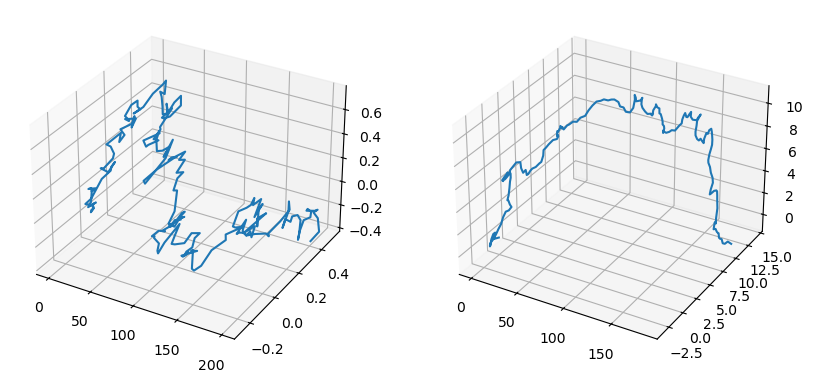

In [129]:
mc = WormlikeChainMC(N=200, b=1.0, kappa=30.0, beta=0.5, seed=0)
positions_initial = mc.positions().copy()
mc.simulate(50)
positions_final = mc.positions().copy()


## side-by-side 3d subplots of the initial and final positions
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax1.plot(positions_initial[:, 0], positions_initial[:, 1], positions_initial[:, 2])
ax2.plot(positions_final[:, 0], positions_final[:, 1], positions_final[:, 2])
plt.show()

We can also make a video of the chain by running sweeps in small batches, and storing the positions at each step.

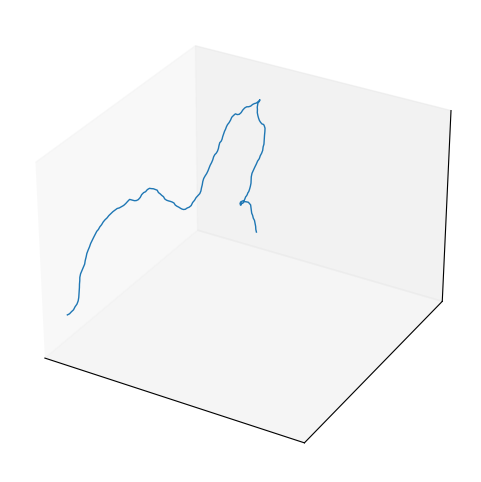

In [ ]:
## Run a few sweeps at a time to get a video of the chain
all_positions = []
mc = WormlikeChainMC(N=200, b=1.0, kappa=30.0, beta=0.5, seed=0)
for _ in range(300):
    mc.simulate(4)
    all_positions.append(mc.positions().copy())
all_positions = np.array(all_positions)




## Boilerplate code to make a video of the chain
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

frames = np.asarray(all_positions)  # (T, N, 3)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
(line,) = ax.plot([], [], [], lw=1)
def init():
    xyz = frames.reshape(-1, 3)
    ax.set_xlim(xyz[:, 0].min(), xyz[:, 0].max())
    ax.set_ylim(xyz[:, 1].min(), xyz[:, 1].max())
    ax.set_zlim(xyz[:, 2].min(), xyz[:, 2].max())
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    return (line,)
def update(i):
    """
    Args:
        i (int): Frame index.

    Returns:
        (tuple): Artists to redraw.
    """
    P = frames[i]  # (N, 3)
    line.set_data(P[:, 0], P[:, 1])
    line.set_3d_properties(P[:, 2])
    return (line,)
ani = FuncAnimation(fig, update, frames=len(frames), init_func=init, interval=50, blit=False)
HTML(ani.to_jshtml())

# from matplotlib.animation import FFMpegWriter
# Save to MP4 (requires ffmpeg installed and on PATH)
# ani.save("wormlike_chain_trajectory.mp4", writer=FFMpegWriter(fps=20))


We can now run many simulations of different chains to compute the average tangent correlation and end-to-end distance. This step can take a while to run, and so you may need to adjust the number of sweeps to run.

In [ ]:
all_tcorr = []
all_r2 = []
for seed in range(30):
    print(f"seed={seed}", flush=True)
    mc = WormlikeChainMC(N=200, b=1.0, kappa=30.0, beta=0.5, seed=seed)
    mc.simulate(4000)
    all_tcorr.append(mc.tangent_correlation()[1])
    all_r2.append(mc.end_to_end()[1])



seed=0
seed=1
seed=2
seed=3
seed=4
seed=5
seed=6
seed=7
seed=8
seed=9
seed=10
seed=11
seed=12
seed=13
seed=14
seed=15
seed=16
seed=17
seed=18
seed=19
seed=20
seed=21
seed=22
seed=23
seed=24
seed=25
seed=26
seed=27
seed=28
seed=29


We can now plot the average tangent correlation and end-to-end distance, and compare them to the theoretical predictions.

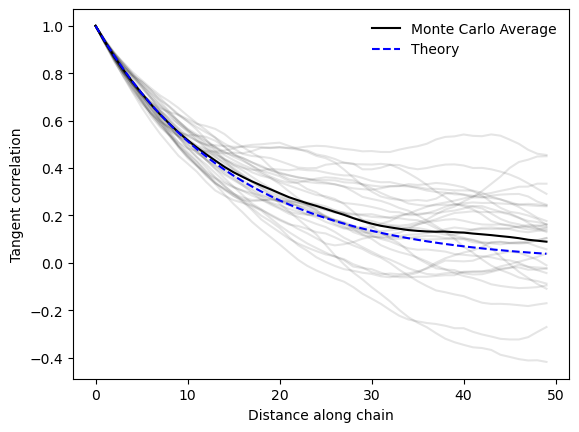

5550.000728818556
6513.1209848422895


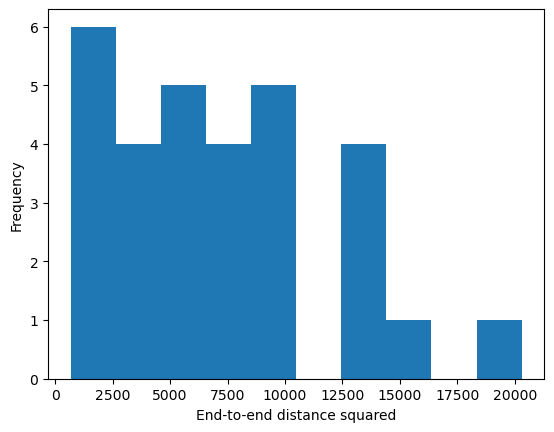

In [134]:
## Plot the tangent correlation
plt.plot(np.array(all_tcorr).T, color="black", alpha=0.1)
scale = mc.tangent_correlation()[0]
plt.plot(np.mean(np.array(all_tcorr), axis=0), color="black", label="Monte Carlo Average")
plt.plot(np.exp(-scale  / (mc.kappa * mc.b) / 0.5), color="blue", linestyle="--", label="Theory")
plt.xlabel("Distance along chain")
plt.ylabel("Tangent correlation")
plt.legend(frameon=False)
plt.show()


# Predicted end-to-end distance
lp = mc.lp * 0.5
L = mc.N * mc.b
R2_theory = 2 * lp * L * (1 - (lp / L) * (1 - np.exp(-L / lp)))
print(R2_theory)
print(np.median(np.array(all_r2)))
plt.hist(np.array(all_r2));
plt.xlabel("End-to-end distance squared")
plt.ylabel("Frequency")
plt.show()



## Download the Instructor's solutions

+ If you are working from a local fork of the entire course, then you already have access to the solutions. In this case, make sure to `git pull` to make sure that you are up-to-date (save your work first).

+ If you are working from a single downloaded notebook, or are working in Google Colab, then you will need to manually download the solutions file from the course repository. The lines below will do this for you.

In [ ]:
import os
import requests
# Check if the "solutions" directory exists. If not, create it and download the solution file
if not os.path.exists('solutions'):
    os.makedirs('solutions')
else:
    print('Directory "solutions" already exists. Skipping creation.')

# Now download the solution file into the directory we just created
url = 'https://raw.githubusercontent.com/williamgilpin/cphy/main/hw/solutions/wormlike_chain.py'
response = requests.get(url)
file_path = os.path.join('solutions', 'wormlike_chain.py')
if not os.path.exists(file_path):
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print(f'File saved to {file_path}')
else:
    print(f'File already exists at {file_path}, not overwritten.')

## import the Instructor's solutions
# from solutions.wormlike_chain import WormlikeChainMC, Bond, random_unit_vec